# Building the Model!

In this file, we will perform **predictive modeling** for the ASUU Strike Effect Analysis Project. The goal is to:
1. determine the most signifcant predictors of CGPA Change based on the strike
2. accurately predict the effect of the strike on a student based on other features. 

In [451]:
# Data Processing
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Preprocessing
from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder, 
                                   StandardScaler,
                                   LabelEncoder,
                                   MinMaxScaler)
from category_encoders import BinaryEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     GridSearchCV)

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC


# Metrics
from sklearn.metrics import (mean_squared_error, 
                             accuracy_score, 
                             confusion_matrix,
                             ConfusionMatrixDisplay, 
                             classification_report)


# import ipywidgets as widgets
# from ipywidgets import interact
# from teaching_tools.widgets import ConfusionMatrixWidget

# Previewing The Data

In [452]:
# all data here include predicted course units

# complete info
df = pd.read_csv("../data/data_with_predicted_course_units.csv")

# contains students with no cgpa before or after 
df_invalid_cgpa = pd.read_csv("../data/incomplete_cgpa_only.csv")

# only contains students with complete cgpa information                                                                                    
df_valid_cgpa = pd.read_csv("../data/valid_cgpa_only.csv")


In [453]:
# Previewing the first row of dat                                                                              
df_valid_cgpa.head(1)

,school,level,age,gender,relationship,faculty,department,strike_effect,challenge,work,...,course_unit,cgpa_before,cgpa_after,cgpa_change,skill_volunteer,skill_relevant,skill_unrelated,skill_artisan,skill_none,skill_count
0,university of lagos,400 Level,22,Male,Single,Engineering,Chemical engineering,I learned how to study better and my grades al...,Trying to remember things we were taught befor...,Worked in a role relevant to my studies,...,23,3.39,3.51,0.12,False,False,True,False,False,1


In [454]:
df_valid_cgpa.prep_after.unique()

array(['Poorly', 'Moderately', 'Very'], dtype=object)

# Select Model Features

In [455]:
# Merging prep columns
# Creating the combined prep change column                                                                             
df_valid_cgpa['prep_after'] = df_valid_cgpa.prep_after.map({'Poorly':0,'Moderately':1,'Very':2}).astype('int64')
df_valid_cgpa['prep_before'] = df_valid_cgpa.prep_before.map({'Poorly':0,'Moderately':1,'Very':2}).astype('int64')
df_valid_cgpa['prep_change'] = df_valid_cgpa.prep_before - df_valid_cgpa.prep_after

def add_prep_change_column(col):
    if col < 0:
        return 'Less'
    elif col == 0:
        return 'Same'
    else:
        return 'More'
    
df_valid_cgpa.prep_change = df_valid_cgpa.prep_change.apply(add_prep_change_column)
df_valid_cgpa.prep_change.unique()

array(['Same', 'Less', 'More'], dtype=object)

In [456]:
features = ['level', 'age', 'gender', 'relationship', 'faculty', 'department', 'work', 'lecture', 'academic_act', 'courses_taken', 'course_unit','prep_change'] # Baseline features
cat_features = ['level', 'gender', 'relationship', 'faculty', 'department', 'work', 'lecture', 'academic_act', 'prep_change'] # Categorical columns
unused_features = ['strike_effect', 'challenge', 'skills','school'] # Unused features                                                                         
contentious = ['age','gender','relationship','lectures'] # Hypothesis testing suggests that this features have no effect on the cgpa change. However, they might assist the model to make minute decisions and improve variances. I'll train some models with and without them and observe the difference.
'''
1. Consider regrouping lectures.

''';

In [457]:
# This is to get a feel of our targets distribution                                                                
df_valid_cgpa.cgpa_change.describe(percentiles=[0.05,0.10,0.25,0.40,0.45,0.55,0.60,0.95,0.99])

count    313.000000
mean      -0.044757
std        0.418056
min       -1.550000
5%        -0.820000
10%       -0.500000
25%       -0.160000
40%       -0.050000
45%        0.000000
50%        0.000000
55%        0.000000
60%        0.030000
95%        0.408000
99%        1.159600
max        3.200000
Name: cgpa_change, dtype: float64

# Exploring Target Column

## Converting Target to categorical

In [458]:
# Converting the target variable into 3 categories.
# same: 0 values from range -0.05 --- 0.05
# reduced: 1 Values lower than -0.05
# increased: 2 Values higher than 0.05                                                  
df_valid_cgpa['cgpa_change_cat'] = df_valid_cgpa.cgpa_change.apply(lambda x: 'reduced' if x < -0.05 else ('same' if x < 0.05 else 'increased'))
df_valid_cgpa.cgpa_change_cat = df_valid_cgpa.cgpa_change_cat.map({'reduced':1,
                                                                   'same':0,
                                                                   'increased':2})

We will use the categorical version of the target column. The exact value of the cgpa change will be harder to predict and actually less valuable for the project purposes.                                                                                                                                  

## Splitting Data

In [459]:
X = df_valid_cgpa[features]
y = df_valid_cgpa.cgpa_change_cat

## Checking target distribution                                                                                

<Axes: xlabel='cgpa_change_cat'>

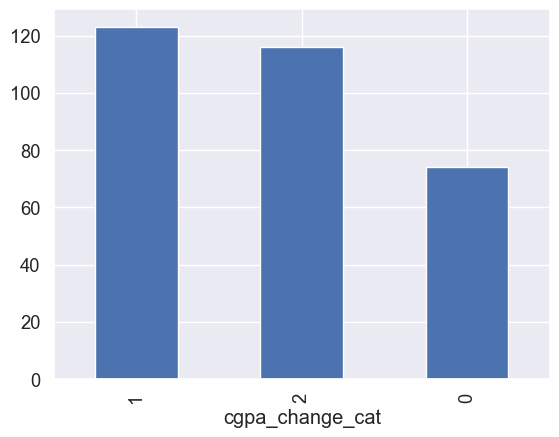

In [460]:
# Visualizing the distribution balance of the data                                                                      
df_valid_cgpa.cgpa_change_cat.value_counts().plot(kind='bar')

Resampling the data will be necessary

In [461]:
# Resampler: Samples the with replacement to achieve class balance                                                                    
sampler = RandomOverSampler(random_state=43)
X, y = sampler.fit_resample(X, y)

<Axes: xlabel='cgpa_change_cat'>

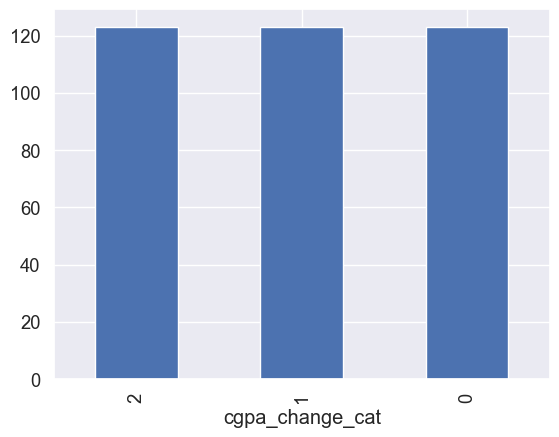

In [462]:
# Revisualizing the distribution                                                                          
y.value_counts().plot(kind='bar')

# Preprocessing 1

In [463]:
# Splitting the available data.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43, shuffle=True, test_size=0.3)

In [464]:
# Encoder: To handle categorical data                                                                     
encoder = OneHotEncoder(handle_unknown='ignore')

# Reduction: To reduce dimensionality of the data.
# I chose to use TruncatedSVD because the high cardinality of the data creates a sparse matrix after OneHotEncoded                                         
reducer = TruncatedSVD(n_components=6)

# Scaler
scaler = StandardScaler()

prep = ColumnTransformer(
    [
        ('encoder' , encoder, cat_features),
        ('reducer' , reducer, []),
        ('scaler' , scaler, [])
    ],
    remainder='passthrough'
)

## Model Selection

In [465]:
linear_model = LogisticRegression()
lgb_model = LGBMClassifier(random_state=43);
svc_model = SVC()
rfc_model = RandomForestClassifier(random_state=43)
lda_model = LinearDiscriminantAnalysis()
knn_model = KNeighborsClassifier(n_neighbors=3)

In [466]:
def train_model(model, model_name):  
    pipeline = Pipeline(
        [
            ('prep', prep),
            ('model', model)
        ]
    )

    pipeline.fit(X_train, y_train)
    # Pipelining model with preprocessing steps
    
    # Making predictions
    y_pred = pipeline.predict(X_test)
    # Calculating Accuracy  
    accuracy = accuracy_score(y_test, y_pred)
    print(f'The accuracy of the {model_name} is {accuracy}.')
    
    # Comparing the count of the predicted categories values with that of the real values 
    comparison = pd.DataFrame(
        {
            'predicted':pd.Series(y_pred).value_counts().sort_index(),
            'real':pd.Series(y_test).value_counts().sort_index()
        }
    )                                                                                 
    print(comparison)
    
    # Building confusion matrix 
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2) 
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(model_name+' Confusion Matrix')
    return(y_pred)

c:\Users\abata\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The accuracy of the linear is 0.4864864864864865.
   predicted  real
0         42    40
1         33    30
2         36    41


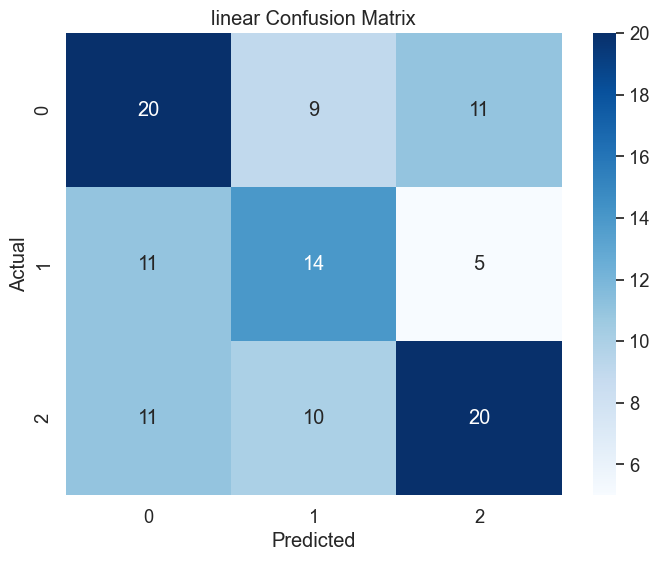

In [467]:
linear_y_pred_one = train_model(linear_model,'linear')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 258, number of used features: 28
[LightGBM] [Info] Start training from score -1.134119
[LightGBM] [Info] Start training from score -1.020360
[LightGBM] [Info] Start training from score -1.146240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

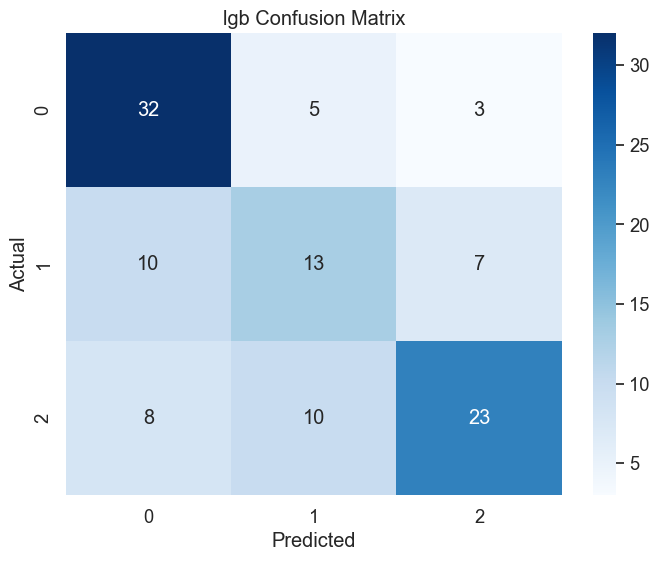

In [468]:
lgb_y_pred_one = train_model(lgb_model,'lgb')

The accuracy of the svm is 0.3063063063063063.
   predicted  real
0       11.0    40
1      100.0    30
2        NaN    41


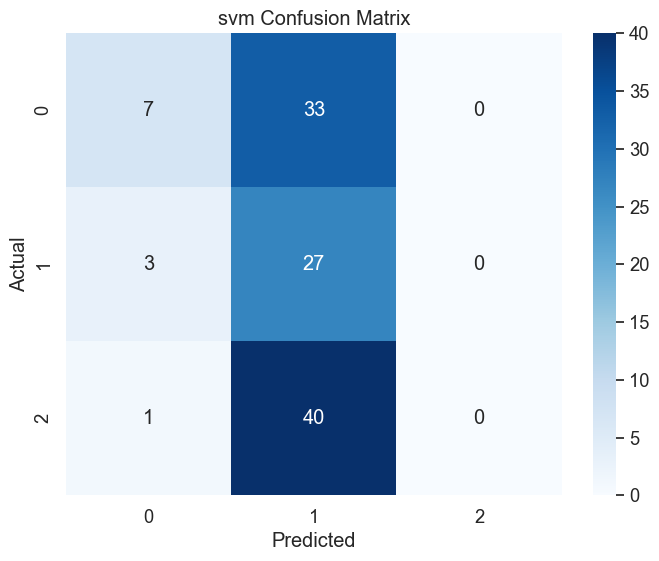

In [469]:
svm_y_pred_one =train_model(svc_model, 'svm')

The accuracy of the rfc is 0.5945945945945946.
   predicted  real
0         44    40
1         42    30
2         25    41


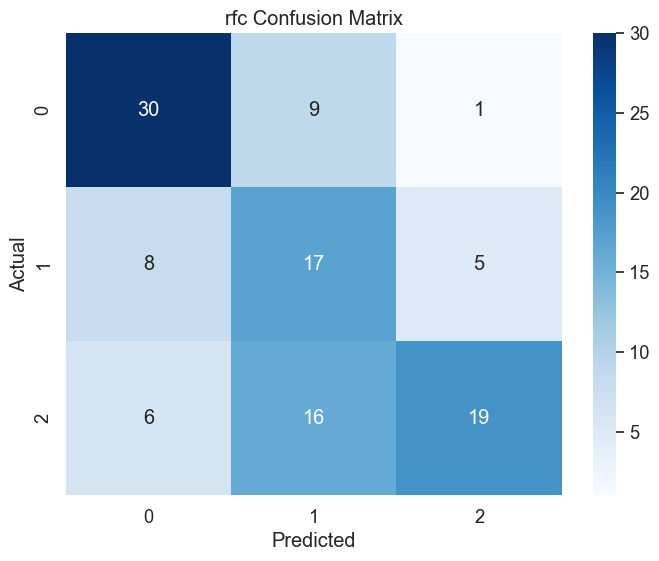

In [470]:
rfc_y_pred_one = train_model(rfc_model, 'rfc')

The accuracy of the knn is 0.5045045045045045.
   predicted  real
0         60    40
1         23    30
2         28    41


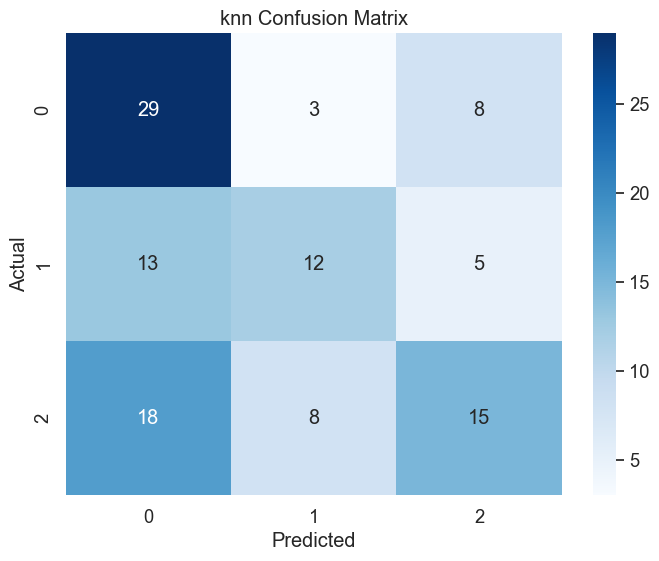

In [471]:
knn_y_pred_one = train_model(knn_model, 'knn')

I'll attempt different preprocessing steps

# Preprocessing 2

In [472]:
# Encoder
encoder = BinaryEncoder()
# Switching to a binary encoder to reduce cardinality

# Reduction
reducer = PCA(n_components=5)
# PCA works well with dense matrix.  

# Scaler
scaler = MinMaxScaler()

prep_two = ColumnTransformer(
    [
        ('encoder' , encoder, cat_features),
        ('reducer' , reducer, []),
        ('scaler' , scaler, [])
    ],
    remainder='passthrough'
)

In [473]:
def train_model_two(model, model_name):
    """This function accepts an intiated model then 
    Returns:an accuracy score and a confusion matrix 
    """  
    pipeline = Pipeline(
        [
            ('prep', prep_two),
            ('model', model)
        ]
    )

    pipeline.fit(X_train, y_train)
    # Pipelining model with preprocessing steps
    
    # Making predictions
    y_pred = pipeline.predict(X_test)
    # Calculating Accuracy  
    accuracy = accuracy_score(y_test, y_pred)
    print(f'The accuracy of the {model_name} is {accuracy}.')
    
    # Comparing the count of the predicted categories values with that of the real values 
    comparison = pd.DataFrame(
        {
            'predicted':pd.Series(y_pred).value_counts().sort_index(),
            'real':pd.Series(y_test).value_counts().sort_index()
        }
    )                                                                                 
    print(comparison)
    
    # Building confusion matrix 
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2) 
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(model_name+' Confusion Matrix')
    return(y_pred)

## Test Models

c:\Users\abata\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The accuracy of the linear is 0.45045045045045046.
   predicted  real
0         44    40
1         32    30
2         35    41


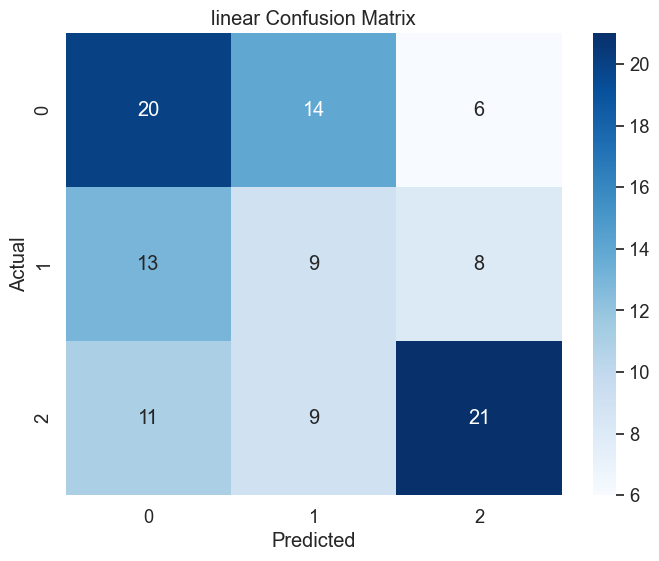

In [474]:
linear_y_pred_two = train_model_two(linear_model, 'linear')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 93
[LightGBM] [Info] Number of data points in the train set: 258, number of used features: 29
[LightGBM] [Info] Start training from score -1.134119
[LightGBM] [Info] Start training from score -1.020360
[LightGBM] [Info] Start training from score -1.146240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

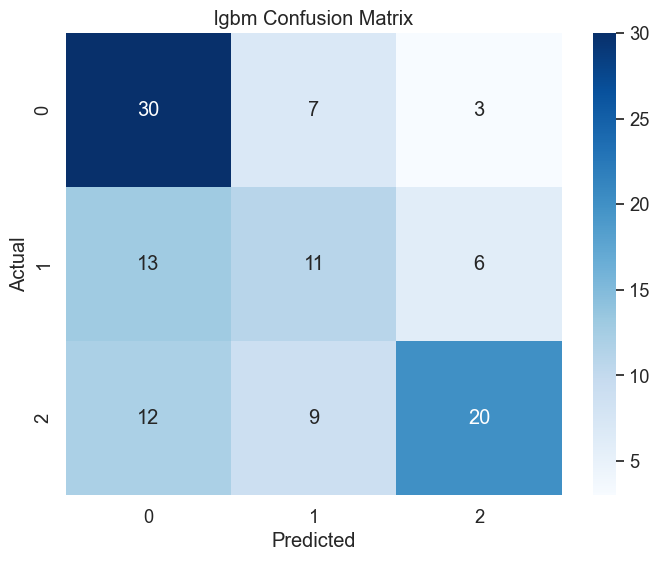

In [475]:
lgb_y_pred_two = train_model_two(lgb_model, 'lgbm')

The accuracy of the svm is 0.3063063063063063.
   predicted  real
0       11.0    40
1      100.0    30
2        NaN    41


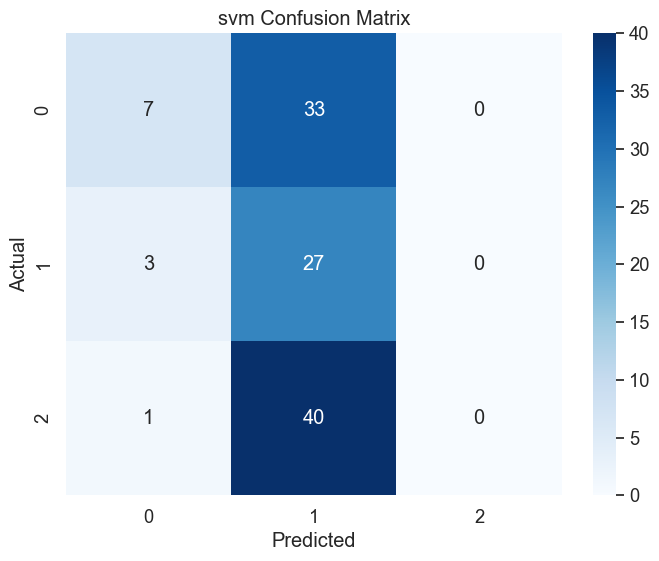

In [476]:
svc_y_pred_two = train_model_two(svc_model, 'svm')

The accuracy of the rfc is 0.6036036036036037.
   predicted  real
0         45    40
1         37    30
2         29    41


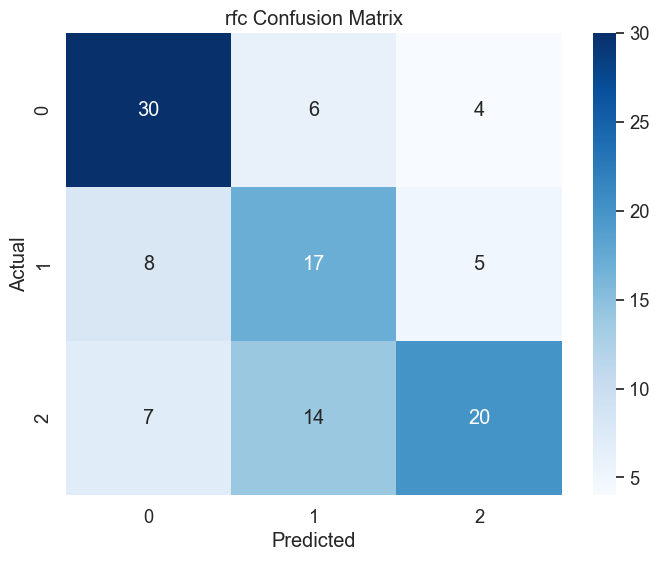

In [477]:
rfc_y_pred_two = train_model_two(rfc_model, 'rfc')

The accuracy of the lda is 0.4594594594594595.
   predicted  real
0         38    40
1         37    30
2         36    41


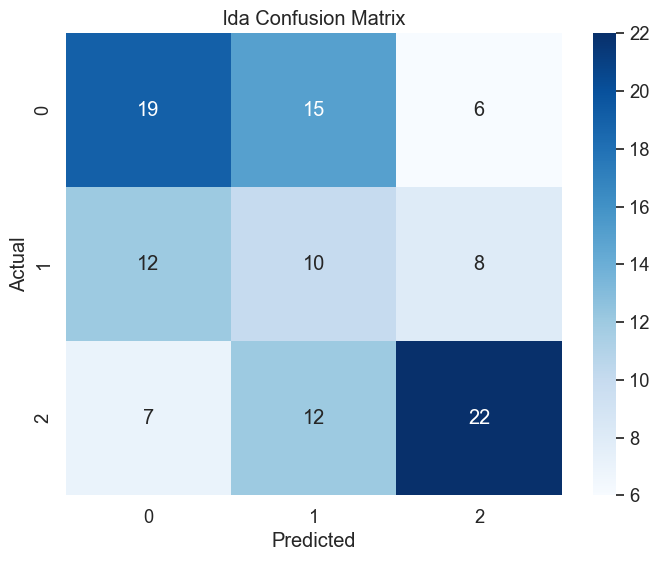

In [478]:
lda_y_pred_two = train_model_two(lda_model, 'lda')

The accuracy of the knn is 0.4594594594594595.
   predicted  real
0         58    40
1         25    30
2         28    41


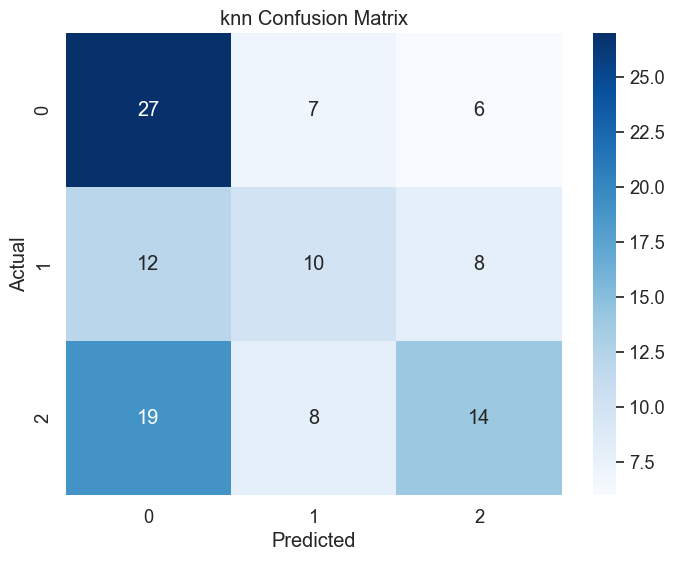

In [479]:
knn_y_pred_two = train_model_two(knn_model, 'knn')

# Model Combination

We will begin to combine multiple models and pipelines to maximize accuracy.
1. The rfc_y_pred_one is best at predicting class 0.
2. The lda_y_pred_two is best at predicting class 2.
3. Use svc_y_pred_two to fill up class 1.                                                                            

In [480]:
# Creating a DataFrame with a combination of different predictions                                                                          
votes = pd.DataFrame(
    {
        'class_0':rfc_y_pred_one,
        'class_1':svc_y_pred_two,
        'class_2':lda_y_pred_two,
        'knn':knn_y_pred_two
    }
)

# votes

In [481]:
final=[]

# Setting up conditionals to maximize individual model strengths                                                                           
for index, row in votes.iterrows():
    if row['class_0'] == 0:
        fine = row['class_0']
    elif row['class_2'] == 2:
        fine = row['class_2']
    elif row['class_0'] == 1:
        fine = 1
    else:
        fine = 2                                                                        
        
    # # if (row['class_0'] == 1) & (row['class_2'] == 2):
    # #     fine = 2
    
    # if (row['class_0'] == 0) & (row['knn'] == 1):
    #     fine = 1
    # if (row['class_0'] == 1) & (row['class_2'] == 2):
    #     fine = 2
    
    final.append(fine)

The accuracy of the combined_models is 0.6126126126126126.


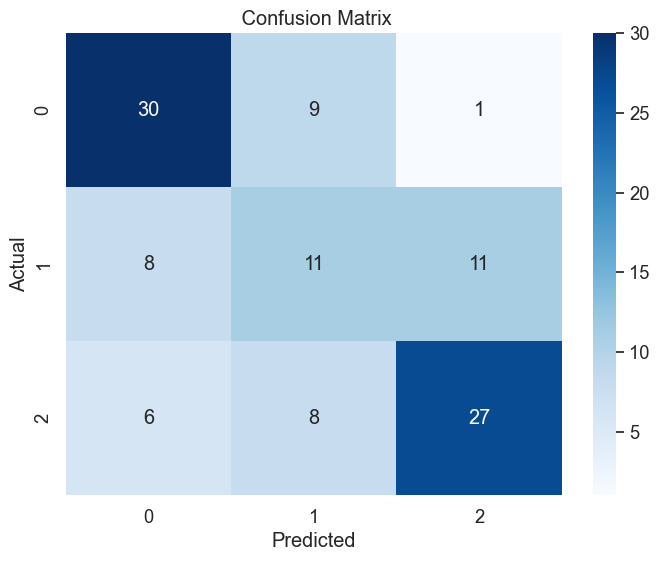

In [482]:
# Accuracy_Score
accuracy = accuracy_score(y_test, final)
print(f'The accuracy of the combined_models is {accuracy}.')

# Confusion Matrix                                                                                 
conf_matrix = confusion_matrix(y_test, final)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(' Confusion Matrix');

# 60.360

Better than the average performanxce of the individual models but still weak.

I'll try to improve the abilities of the rfc and lda models at predicting their specific classes.                                                                   

In [483]:
lda_model = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', n_components=2, tol=0.001)
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=43)


The accuracy of the rfc is 0.6126126126126126.
   predicted  real
0         42    40
1         37    30
2         32    41


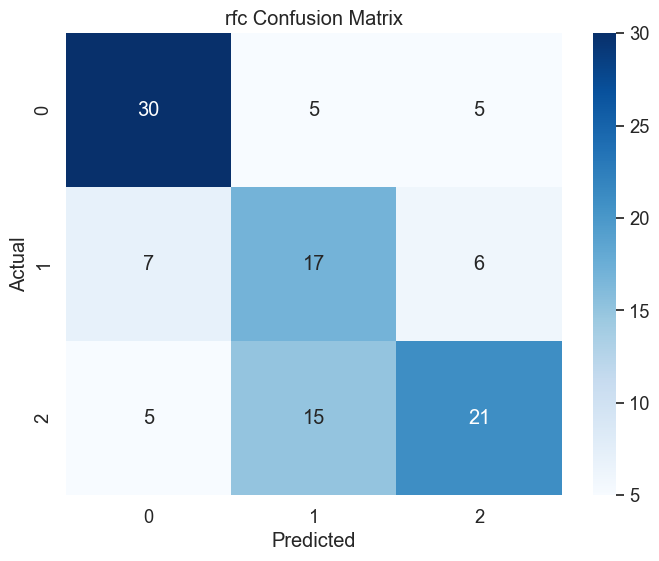

In [484]:
rfc_y_pred_two = train_model_two(rfc_model, 'rfc')

The accuracy of the lda is 0.4774774774774775.
   predicted  real
0         39    40
1         34    30
2         38    41


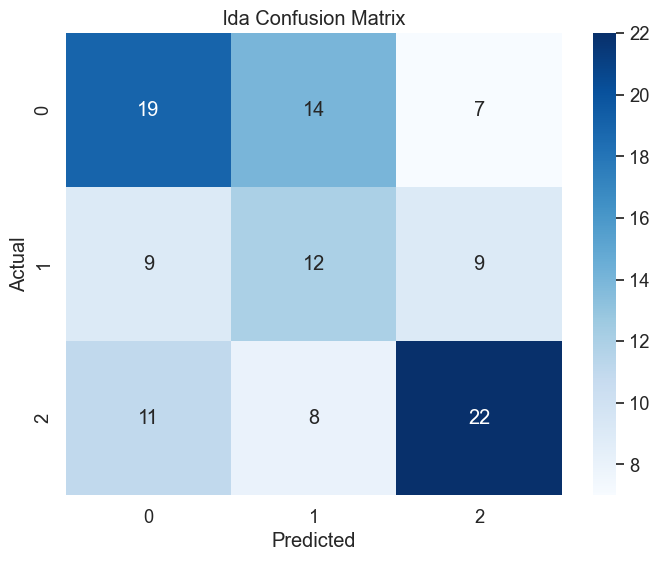

In [485]:
lda_y_pred_two = train_model_two(lda_model, 'lda')

In [486]:
votes = pd.DataFrame(
    {
        'class_0':rfc_y_pred_two,
        'class_1':svc_y_pred_two,
        'class_2':lda_y_pred_two,
        'knn':knn_y_pred_two
    }
)

# votes

In [487]:
final=[]
for index, row in votes.iterrows():
    if row['class_0'] == 0:
        fine = row['class_0']
    elif row['class_2'] == 2:
        fine = row['class_2']
    elif row['class_0'] == 1:
        fine = 1
    else:
        fine = 2                                                                        
        
    # # if (row['class_0'] == 1) & (row['class_2'] == 2):
    # #     fine = 2
    
    # if (row['class_0'] == 0) & (row['knn'] == 1):
    #     fine = 1
    # if (row['class_0'] == 1) & (row['class_2'] == 2):
    #     fine = 2
    
    final.append(fine)

The accuracy of the combined_models is 0.6396396396396397.


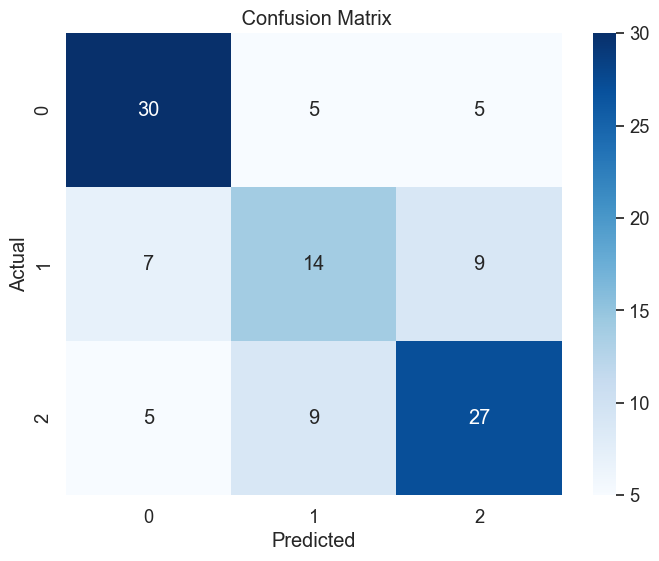

In [488]:
accuracy = accuracy_score(y_test, final)
print(f'The accuracy of the combined_models is {accuracy}.')

conf_matrix = confusion_matrix(y_test, final)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(' Confusion Matrix');

This is the best model yet (although marginally and in terms of accuracy. In other terms, the distribution of correctly predicted classes is much better). The false negatives and false positives are all single digits now.                                                                

# Using a One Vs One Approach                                                                            

I tried implementing this with the OnevsOne sklearn library but that didn't go well. However, I understand the theory and I only have 3 classes so I'll attempt to solve it manually.In this process a binary classification model is created to distinguish between every possible pairing of your classes. For a 3 class system, there are 3 distinct pairs (A-B == B-A). The classes are:
1. Same vs Reduced
2. Same vs Increased
3. Reduced vs Increased
Three models will be built and optimized to perform this classifications and their results will be combined to give the final result.                                                              

## Splitting The Data                                                                               

I'll use the rfc and lgb models to build the classification tasks                                                                        

In [489]:
binary_rfc_model = RandomForestClassifier(
    random_state=43,
    n_estimators=2000,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=False,
    class_weight='balanced'
)                              

In [490]:
def perform_one_vs_one_training(train_df, test_df, model, model_name): 
    predictions = []
    for category in [0, 1, 2]:
        # Create a copy of the original DataFrame for the current category
        train_category_df = train_df.copy()
        test_category_df = test_df.copy()
        
        # Filter and assign the value 5 to rows not matching the current category
        train_category_df.loc[train_category_df['cgpa_change_cat'] != category, 'cgpa_change_cat'] = 5
        
        train_df_X = train_category_df[features]
        train_df_y = train_category_df.cgpa_change_cat
        
        test_df_X = test_category_df[features]
        test_df_y = test_category_df.cgpa_change_cat
        
        test_df_y = np.where(test_df_y != category, 5, test_df_y)
    

        # Preprocessing
        
        # Encoder: To handle categorical data                                                                     
        encoder = OneHotEncoder(handle_unknown='ignore')

        # Reduction: To reduce dimensionality of the data.
        # I chose to use TruncatedSVD because the high cardinality of the data creates a sparse matrix after OneHotEncoding                                        
        reducer = TruncatedSVD(n_components=6)

        # Scaler
        scaler = StandardScaler()

        prep = ColumnTransformer(
            [
                ('encoder' , encoder, cat_features),
                ('reducer' , reducer, []),
                ('scaler' , scaler, [])
            ],
            remainder='passthrough'
        )

        # Create Pipeline    
        pipeline = Pipeline(
            [
                ('prep', prep),
                ('model', model)
            ]
        )

        pipeline.fit(train_df_X, train_df_y)
        # Pipelining model with preprocessing steps
        
        # Making predictions
        y_pred = pipeline.predict(test_df_X)
        # Calculating Accuracy  
        accuracy = accuracy_score(test_df_y, y_pred)
        print(f'The accuracy of the {category} category is {accuracy}.')
        
        # Building confusion matrix 
        conf_matrix = confusion_matrix(test_df_y, y_pred)

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.2) 
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(model_name+' Confusion Matrix')
        
        predictions.append(y_pred)
        
    final = pd.DataFrame(
        {
            'zeroes':predictions[0],
            'ones':predictions[1],
            'twos':predictions[2]
        }
    )
    
    return final

In [491]:
print(len(df_valid_cgpa))
sample_X = df_valid_cgpa[features]
sample_y = df_valid_cgpa.cgpa_change_cat
# Resampler: Samples the with replacement to achieve class balance                                                                    
sampler = RandomOverSampler(random_state=43)
sample_X, sample_y = sampler.fit_resample(sample_X, sample_y)
sample_X['cgpa_change_cat'] = sample_y
df_valid_cgpa = sample_X.copy()
print(len(df_valid_cgpa))

313
369


In [492]:
X = df_valid_cgpa[features]
y = df_valid_cgpa.cgpa_change_cat

# Splitting the available data.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43, shuffle=True, test_size=0.3)

X_train['cgpa_change_cat'] = y_train
X_test['cgpa_change_cat'] = y_test

train_data = X_train.copy()
test_data = X_test.copy()

The accuracy of the 0 category is 0.7747747747747747.
The accuracy of the 1 category is 0.7477477477477478.
The accuracy of the 2 category is 0.6486486486486487.


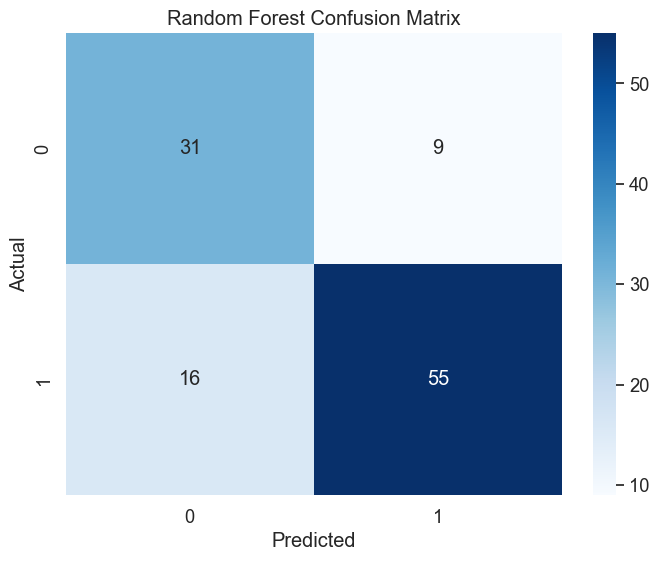

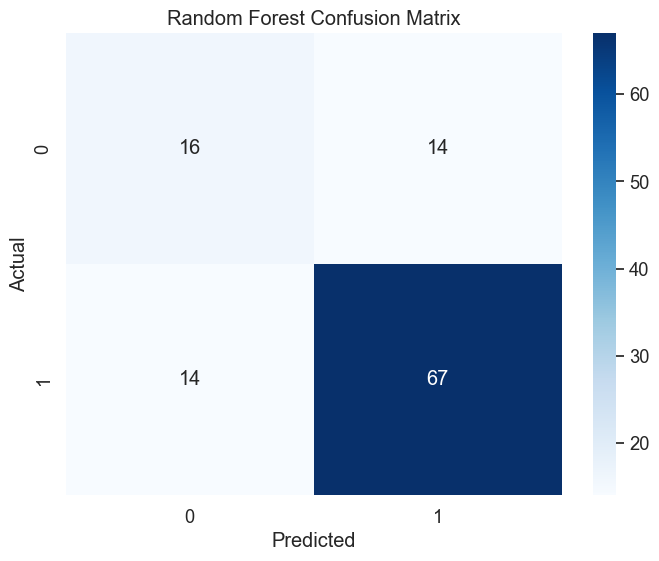

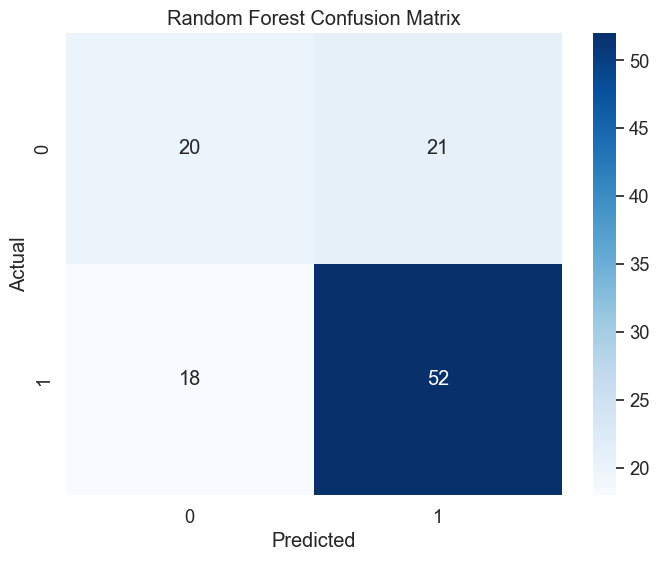

In [493]:
final = perform_one_vs_one_training(train_df=train_data, test_df=test_data, model=binary_rfc_model, model_name='Random Forest')

In [494]:
final_list = []
for index, row in final.iterrows():
    if (row['ones'] != 5) & (row['zeroes'] != 5):
        final_list.append(row['ones'])
    elif row['zeroes'] != 5:
        final_list.append(row['zeroes'])
    elif (row['ones'] != 5) & (row['zeroes'] != 5):
        final_list.append(row['ones'])
    elif row['ones'] != 5:
        final_list.append(row['ones'])
    else:
        final_list.append(2)
        
final['final'] = final_list       

In [495]:
final.final.unique()

array([0, 1, 2], dtype=int64)

The accuracy is 0.6396396396396397.


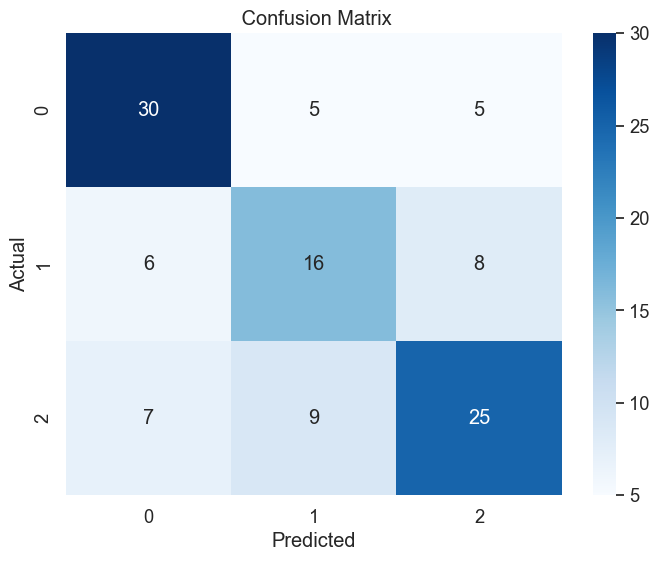

In [496]:
accuracy = accuracy_score(y_test, final.final)
print(f'The accuracy is {accuracy}.')

# Building confusion matrix 
conf_matrix = confusion_matrix(y_test, final.final)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(' Confusion Matrix');

# Seeking other ways to improve performance

While the accuracy score of the one vs one approach was similar to the model combination approach, it sports a better confusion matrix. This however suggest that the path to improving the model performance isn't in creative modelling so, let's take a second look at the training data.                                

In [497]:
# department
department_count = df_valid_cgpa.department.value_counts()
print(len(department_count[department_count <= 5]))
print(len(df_valid_cgpa.department.unique()))

43
66


In [498]:
df_valid_cgpa

,level,age,gender,relationship,faculty,department,work,lecture,academic_act,courses_taken,course_unit,prep_change,cgpa_change_cat
0,400 Level,22,Male,Single,Engineering,Chemical engineering,Worked in a role relevant to my studies,No noticeable change,Rarely: I engaged in academic activities once ...,10,23,Same,2
1,400 Level,23,Female,Single,Engineering,Chemical engineering,Did not work during the strike,No noticeable change,Rarely: I engaged in academic activities once ...,10,23,Less,2
2,400 Level,21,Male,Dating,Engineering,Chemical engineering,Worked in a role unrelated to my studies,Fewer lecturers attended classes,Rarely: I engaged in academic activities once ...,10,23,Same,2
3,400 Level,29,Male,Dating,Social Sciences,Political science,Worked in a role unrelated to my studies,No noticeable change,Rarely: I engaged in academic activities once ...,7,18,Less,2
4,300 Level,24,Male,Single,Education,Educational foundations,Did not work during the strike,Worse lectures after the strike,Never: I did not engage in any academic activi...,9,18,Less,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,400 Level,23,Male,Single,Engineering,Chemical engineering,Worked in a role unrelated to my studies,No noticeable change,Never: I did not engage in any academic activi...,10,23,Less,2
365,200 Level,23,Male,Single,Engineering,Chemical engineering,Worked in a role unrelated to my studies,Fewer lecturers attended classes,Never: I did not engage in any academic activi...,10,21,More,2
366,400 Level,29,Male,Dating,Social Sciences,Political science,Worked in a role unrelated to my studies,No noticeable change,Rarely: I engaged in academic activities once ...,7,18,Less,2
367,200 Level,20,Male,Single,Management Sciences,Accounting,Worked in a role unrelated to my studies,Fewer lecturers attended classes,Sometimes: I engaged in academic activities oc...,7,18,More,2
